In [487]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import patsy
import datetime as dt

In [150]:
#read data
df = pd.read_csv("Crime_Data_from_2010_to_Present.csv")

**Redesign the data frame**

In [151]:
df["time"] = df["Date Occurred"].str.split('/')
df["Year"] = pd.to_numeric(df["time"].str[2])
df["Month"] = pd.to_numeric(df["time"].str[0])
df["Day"] = pd.to_numeric(df["time"].str[1])
df.drop(columns=["time"], inplace = True)
df["date"] = df[["Month", "Day", "Year"]].values.tolist()

In [176]:
df["Num"] = np.ones(df.shape[0])

In [152]:
#Cut the data frame
df = df.loc[(df["Year"] >= 2015) & (df["Year"] < 2019),:]

**Holidays related**

In [160]:
Holi_2015 = ["01/01/2015", "01/19/2015", "02/16/2015", "03/25/2015", "07/04/2015", "09/07/2015", "10/12/2015", 
        "11/11/2015", "11/26/2015", "12/25/2015"]
Holi_2016 = ["01/01/2016", "01/18/2016", "02/15/2016", "03/30/2016", "07/04/2016", "09/05/2016", "10/10/2016", 
        "11/11/2016", "11/24/2016", "12/25/2016"]
Holi_2017 = ["01/01/2017", "01/16/2017", "02/20/2017", "03/29/2017", "07/04/2017", "09/04/2017", "10/09/2017", 
        "11/11/2017", "11/23/2017", "12/25/2017"]
Holi_2018 = ["01/01/2018", "01/15/2018", "02/19/2018", "03/28/2018", "07/04/2018", "09/03/2018", "10/08/2018", 
        "11/11/2018", "11/22/2018", "12/25/2018"]
holidays = Holi_2015 + Holi_2016 + Holi_2017 + Holi_2018

In [163]:
df["is_holiday"] = df["Date Occurred"].isin(holidays)

**Number of crimes on holidays**

In [291]:
num_crime_holiday = df.groupby(["Month"]).sum().is_holiday

In [209]:
num_holidays = [2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 3, 3]

In [210]:
for i in range(1,13):
    if num_holidays[i-1] != 0:
        num_crime_holiday[i] = num_crime_holiday[i]/num_holidays[i-1]

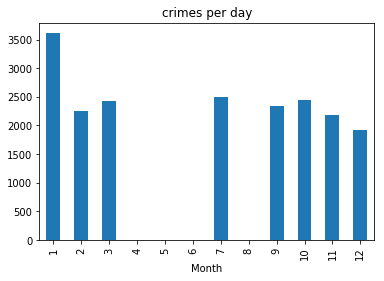

In [217]:
num_crime_holiday.plot(kind="bar", title="crimes per day")

**Number of crimes on non-holidays**

In [213]:
num_crime_nonholiday = df.groupby(["Month"]).sum().Num - num_crime_holiday

In [214]:
num_nonholidays = [29, 27, 30, 30, 31, 30, 30, 31, 29, 30, 27, 28]

In [215]:
for i in range(1,13):
    num_crime_nonholiday[i] = num_crime_nonholiday[i]/num_nonholidays[i-1]

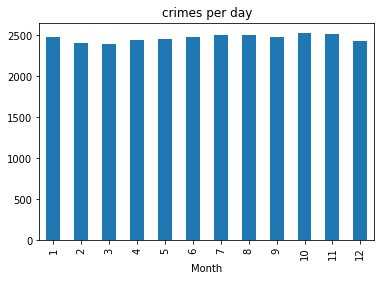

In [218]:
num_crime_nonholiday.plot(kind="bar", title="crimes per day")

**Delete month 4, 5, 6, 8**

In [224]:
new_num_crime_holiday = num_crime_holiday.drop(labels=[4,5,6,8])

In [225]:
new_num_crime_nonholiday = num_crime_nonholiday.drop(labels=[4,5,6,8])

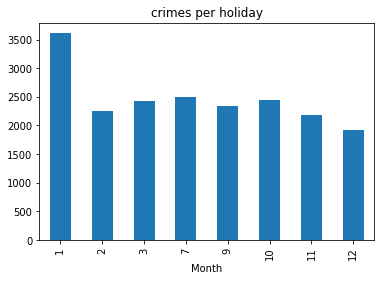

In [456]:
new_num_crime_holiday.plot(kind="bar", title="crimes per holiday")

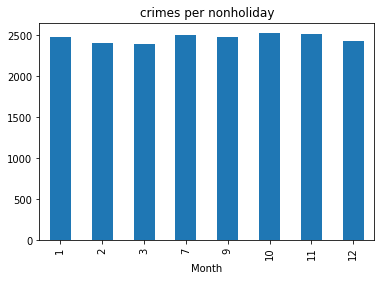

In [227]:
new_num_crime_nonholiday.plot(kind="bar", title="crimes per nonholiday")

**Hypothesis testing**

In [263]:
stats.wilcoxon(list(new_num_crime_holiday), list(new_num_crime_nonholiday))

WilcoxonResult(statistic=10.0, pvalue=0.2626182904425206)

Since the sample size too small, I tried another way

**The Monte Carlo Wilcoxon signed rank test**

Null Hypothesis: the difference between average number of crimes per day on holidays and non-holidays is 0

Alternative Hypothesis: the difference between average number of crimes per day on holidays and non-holidays is not 0

In [274]:
diff = new_num_crime_holiday - new_num_crime_nonholiday
w_rand = []
for b in range(10000):
    sign = np.random.choice([-1,1], 8)
    srank = stats.rankdata(abs(diff))*sign
    w_rand.append(srank[srank>0].sum())
prob_larger = np.mean(10 <= np.array(w_rand))
prob_smaller = np.mean(10 >= np.array(w_rand))
p_value = 2*min([prob_larger, prob_smaller])

In [275]:
p_value

0.3092

since p value is larger than 0.05, we fail to reject the null hypothesis.

# 48-Month Data 

**Crime on holidays**

In [360]:
num_crime_holiday_2 = df.groupby(["Year", "Month"]).sum().is_holiday.reset_index()

In [361]:
num_crime_holiday_2["time"] = num_crime_holiday_2["Year"].apply(str) +"/" + num_crime_holiday_2["Month"].apply(str)

In [370]:
mean_num_crime_holiday = []
for i in range(num_crime_holiday_2.shape[0]):
    if num_holidays[num_crime_holiday_2["Month"][i]-1] != 0:
        a = num_crime_holiday_2["is_holiday"][i]
        b = num_holidays[num_crime_holiday_2["Month"][i]-1]
        mean_num_crime_holiday.append(a/b)
    else:
        mean_num_crime_holiday.append(0)

In [374]:
num_crime_holiday_2["Average"] = mean_num_crime_holiday
num_crime_holiday_2 = num_crime_holiday_2[num_crime_holiday_2["is_holiday"] != 0]

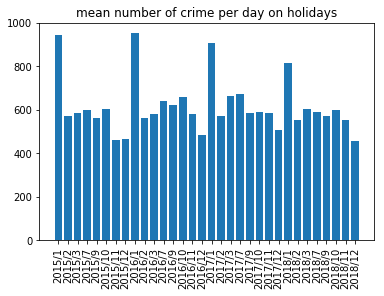

In [379]:
plt.bar(num_crime_holiday_2["time"], num_crime_holiday_2["Average"])
plt.title("mean number of crime per day on holidays")
locs, labels = plt.xticks(rotation=90)

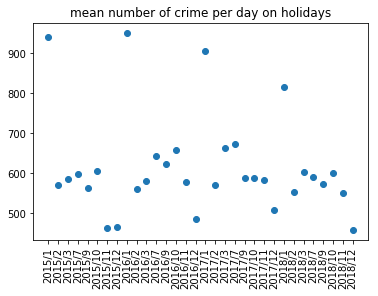

In [454]:
plt.scatter(num_crime_holiday_2["time"], num_crime_holiday_2["Average"])
plt.title("mean number of crime per day on holidays")
locs, labels = plt.xticks(rotation=90)

**Crimes on non-holidays**

In [394]:
num_crime_nonholiday_2 = df.groupby(["Year", "Month"]).sum().Num - df.groupby(["Year", "Month"]).sum().is_holiday
num_crime_nonholiday_2 = num_crime_nonholiday_2.reset_index()
num_crime_nonholiday_2.columns = ["Year", "Month", "Num"]
num_crime_nonholiday_2["time"] = num_crime_nonholiday_2["Year"].apply(str) +"/" + num_crime_nonholiday_2["Month"].apply(str)
mean_num_crime_nonholiday = []
for i in range(num_crime_nonholiday_2.shape[0]):
    a = num_crime_nonholiday_2["Num"][i]
    b = num_nonholidays[num_crime_nonholiday_2["Month"][i]-1]
    mean_num_crime_nonholiday.append(a/b)
num_crime_nonholiday_2["Average"] = mean_num_crime_nonholiday

In [396]:
num_crime_nonholiday_2 = num_crime_nonholiday_2[~num_crime_nonholiday_2["Month"].isin([4,5,6,8])]

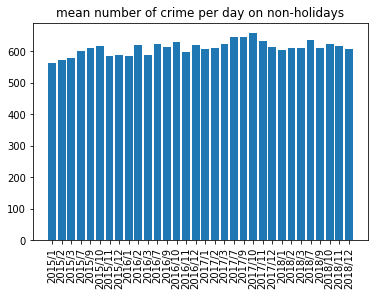

In [398]:
plt.bar(num_crime_nonholiday_2["time"], num_crime_nonholiday_2["Average"])
plt.title("mean number of crime per day on non-holidays")
locs, labels = plt.xticks(rotation=90)

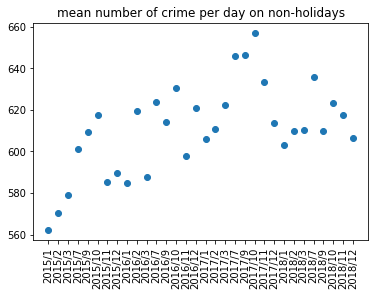

In [455]:
plt.scatter(num_crime_nonholiday_2["time"], num_crime_nonholiday_2["Average"])
plt.title("mean number of crime per day on non-holidays")
locs, labels = plt.xticks(rotation=90)

In [399]:
stats.wilcoxon(list(num_crime_holiday_2["Average"]), list(num_crime_nonholiday_2["Average"]))

WilcoxonResult(statistic=177.0, pvalue=0.10377793246230706)

Fail to reject Null hypothesis

# 4-year Data

In [492]:
num_crime_holiday_3 = df.groupby(["Date Occurred"]).sum().is_holiday.reset_index()
num_crime_holiday_3 = num_crime_holiday_3[num_crime_holiday_3["is_holiday"] != 0]

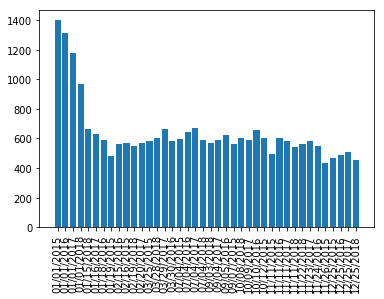

In [435]:
plt.bar(num_crime_holiday_3["Date Occurred"], num_crime_holiday_3["is_holiday"])
locs, labels = plt.xticks(rotation=90)

In [493]:
num_crime_nonholiday_3 = df.groupby(["Date Occurred"]).sum().Num - df.groupby(["Date Occurred"]).sum().is_holiday
num_crime_nonholiday_3 = num_crime_nonholiday_3.reset_index()
num_crime_nonholiday_3.columns=(["Date Occurred", "Num"])
num_crime_nonholiday_3 = num_crime_nonholiday_3[num_crime_nonholiday_3["Num"] != 0]

**Wilcoxon ranked sum test**

Null hypothesis: the distribution of number of crimes on the holidays is the same as the distribution of number of crimes on the non holidays

Alternative hypothesis: there is a shift between two distributions

In [433]:
stats.ranksums(num_crime_holiday_3["is_holiday"], num_crime_nonholiday_3["Num"])

RanksumsResult(statistic=-2.2078320550103623, pvalue=0.0272559826419051)

the result rejects the null hypothesis and suggests that there is a shift between two distribution. However, the shift is less than 0 which means the number of crimes on holidays is less than the number of crimes on non-holidays

# Linear Regression

In [494]:
num_crime_holiday_3["Date Occurred"] = pd.to_datetime(num_crime_holiday_3["Date Occurred"])
num_crime_nonholiday_3["Date Occurred"] = pd.to_datetime(num_crime_nonholiday_3["Date Occurred"])
num_crime_holiday_3["Date Occurred"] = num_crime_holiday_3["Date Occurred"].map(dt.datetime.toordinal)
num_crime_nonholiday_3["Date Occurred"] = num_crime_nonholiday_3["Date Occurred"].map(dt.datetime.toordinal)

In [511]:
x = num_crime_holiday_3["Date Occurred"]
y = num_crime_holiday_3["is_holiday"]
x_m = np.column_stack((np.ones(len(x)),x))
y_m = np.matrix(y)
W = np.linalg.inv(x_m.T.dot(x_m)).dot(x_m.T).dot(y)

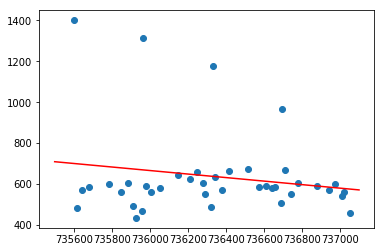

In [513]:
plt.scatter(x, y)
x_s = np.linspace(735500, 737100, 1000)
plt.plot(x_s, W[0] + W[1]*x_s, color = "r")
plt.show()

In [515]:
x = num_crime_nonholiday_3["Date Occurred"]
y = num_crime_nonholiday_3["Num"]
x_m = np.column_stack((np.ones(len(x)),x))
y_m = np.matrix(y)
W = np.linalg.inv(x_m.T.dot(x_m)).dot(x_m.T).dot(y)

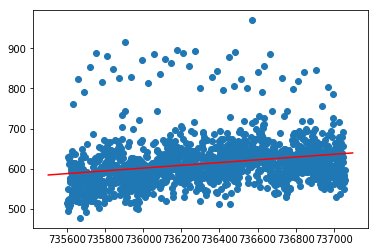

In [516]:
plt.scatter(x, y)
x_s = np.linspace(735500, 737100, 1000)
plt.plot(x_s, W[0] + W[1]*x_s, color = "r")
plt.show()